Code wird auch regelmäßig bei https://github.com/EvanderCorvus/AgentSimulation updated.


In [586]:
import torch as tr
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [587]:
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
# print(device)
tr.set_default_dtype(tr.float)
tr.set_default_device(device)

In [588]:
#hyperparameters
batch_size = 512
epoch = 50
t_update = 10
g = 0.6
max_steps = 100

In [589]:
def d(L,a=1):
    direction_mapping = [
        tr.tensor([0,1],dtype=tr.float).to(device), #up
        tr.tensor([0,-1],dtype=tr.float).to(device),#down
        tr.tensor([-1,0],dtype=tr.float).to(device), #left
        tr.tensor([1,0],dtype=tr.float).to(device) #right
    ]
    return tr.stack(direction_mapping).to(device)[L]*a


In [590]:
#Agent Class
class Agent(nn.Module):
    def __init__(self, x, y,v0, xi):#initialize agent at location (-0.5,-0.5) with bias 0
        super(Agent, self).__init__()
        self.x=x #x coordinate
        self.y=y #y coordinate
        self.v0=v0 
        self.xi=xi
        self.input = nn.Linear(4, 64,dtype=tr.float) #input layer
        self.hidden1 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        self.hidden2 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        # self.hidden3 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        # self.hidden4 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        # self.hidden5 = nn.Linear(64, 32, dtype = tr.float) #hidden layer
        self.output = nn.Linear(64, 4,dtype=tr.float) #output layer
        self.activation = nn.LeakyReLU() #activation function
        # self.dropout = nn.Dropout(p=0.2) #dropout layer

    def forward(self, x): #forward pass
        x1 = self.activation(self.input(x))
        x2 = self.activation(self.hidden1(x1))
        x3 = self.activation(self.hidden2(x2))
        # x4 = self.activation(self.hidden3(x3))
        # x5 = self.activation(self.hidden4(x4))
        # x6 = self.activation(self.hidden5(x5))
        x7 = self.output(x3)
        return x7
    

    def move(self,Q,e): 

        L=tr.argmax(Q,dim=1)
        random_vector = tr.rand(L.shape,dtype=tr.float).to(device)
        bool_vector = random_vector<e
        #randomly choose action with probability e
        L[bool_vector] = tr.randint(0,4,(1,),dtype=tr.int64).to(device) 
        a = tr.tensor(0.0357,dtype=tr.float).to(device)
        dr = d(L,a) 
        dx = dr[:,0]
        dy = dr[:,1]

        self.x+=dx
        self.y+=dy

    def R(self,F,Q):
        F = F.reshape(batch_size,2).to(device)

        dist = tr.stack([self.x-0.5,self.y],dim=1).to(device)
        dist_norm = tr.norm(dist,dim=1).to(device)
        di = d(tr.argmax(Q,dim=1))
        reshaped_di = di.unsqueeze(1).to(device)

        reshaped_force = F.unsqueeze(1).to(device)

        work = tr.squeeze(tr.sum(reshaped_di*reshaped_force,dim=2)).to(device)

        return -0.5*work-0.5*dist_norm   
# L = tr.argmax(Q,dim=1).to(device)
#         d_i = d(L)

#         dx = d_i[:,0]
#         Fx = F[0]

#         e_x = dx-Fx/(self.xi*self.v0)

#         dy = d_i[:,1]
#         Fy = F[1]
#         e_y = dy-Fy/(self.xi*self.v0)

#         e = tr.stack([e_x,e_y],dim=1).to(device)
#         nn.functional.normalize(e,dim=1)
#         #print(e.shape,F.T.shape,d_i.T.shape)
        
#         k = tr.diag(tr.matmul((e+F.T),(d_i*0.0357).transpose(0,1))).to(device)

#         dt = 0.0357/k.to(device)

In [591]:
#Simulation Setup
def episode(agent,t_agent,t_update, max_steps,g,optimizer,e):
    
    X,Y = agent.x,agent.y
    for dT in range(max_steps):
        optimizer.zero_grad()#zero gradients

        if dT%t_update==0:#update target agent every 100 steps
            t_agent.load_state_dict(agent.state_dict())


        state = tr.stack([agent.x, agent.y, -tr.abs(agent.y), tr.zeros(agent.x.shape[0],dtype=tr.float).to(device)],dim=1) #state
        Q1 = agent.forward(state)
        agent.move(Q1,e)

        state2 = tr.stack([agent.x, agent.y, -tr.abs(agent.y), tr.zeros(agent.x.shape[0],dtype=tr.float).to(device)],dim=1) #state
        Q2 = t_agent.forward(state2)#.transpose(0,1)) #Q value of target agent
        
        F = tr.stack([-tr.abs(agent.y),tr.zeros(agent.y.shape).to(device)]).to(device)

        maxQ1 = tr.max(Q1,dim=1)[0]
        maxQ2 = tr.max(Q2,dim=1)[0]

        #target Q value
        target = agent.R(F, Q1) + g*maxQ2 

        criterion = nn.MSELoss()
        loss = criterion(target,maxQ1) #loss

        #backpropagate
        loss.backward()

        #update weights                         
        optimizer.step()   

        #save data to track agent                    
        newX = X.reshape(batch_size,-1)
        newY = Y.reshape(batch_size,-1)
        newx = agent.x[:,None]
        newy = agent.y[:,None]
       
        X = tr.cat((newX,newx),dim=1)
        Y = tr.cat((newY,newy),dim=1)

    
    return X,Y



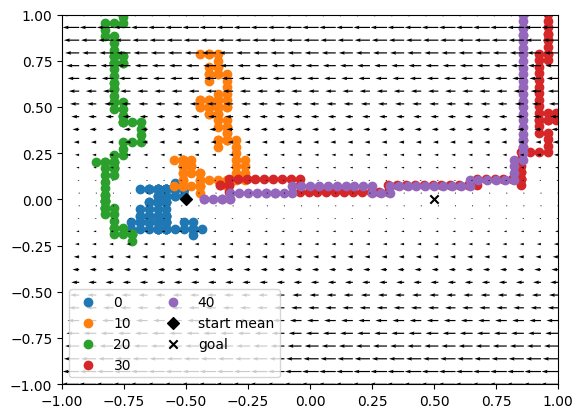

In [592]:
#Simulation
mu, sig = -0.5, 0.1
x = tr.randn(batch_size, dtype=tr.float).to(device)*sig + mu
y = tr.randn(batch_size, dtype=tr.float).to(device)*sig
agent = Agent(x,y,1,1).to(device)

t_agent = Agent(x,y,1,1).to(device)
t_agent.load_state_dict(agent.state_dict()) #copies weights from agent to t_agent
t_agent.eval()


optimizer = tr.optim.Adam(agent.parameters(), lr=0.001)

for i in range(epoch):
    e =1-i/epoch
    X,Y = episode(agent, t_agent, t_update = t_update, max_steps = max_steps, g=g, optimizer=optimizer,e=e)
    agent.x = tr.randn(batch_size, dtype=tr.float).to(device)*sig + mu
    agent.y = tr.randn(batch_size, dtype=tr.float).to(device)*sig
    
    
    if i%10 == 0:
        x,y = X[0].detach().to('cpu').numpy(),Y[0].detach().to('cpu').numpy()
        plt.scatter(x,y,label=int(i))#,c=np.arange(len(x)),cmap='viridis')
    

X1,Y1 = np.meshgrid(np.linspace(-1,1,30),np.linspace(-1,1,30))  
U=-np.abs(Y1)
V=np.zeros(U.shape)
plt.quiver(X1,Y1,U,V)


plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(-0.5,0,c='black',label='start mean',marker='D')    
plt.scatter(0.5,0,c='black',label='goal',marker='x')
plt.legend(ncol=2,loc='best')
plt.show()
